# Imports and Setup

In [14]:
from pyspark import SparkContext, SparkConf
import zipfile
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
from itertools import permutations
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans as SKMeans

try:
    from cv2 import resize as imresize
except:
    !pip install opencv-python
    from cv2 import resize as imresize

In [15]:
IMAGE_DIR = './dataset/'

# Functions and Classes

In [16]:
def RGBfloat2RGBint(arr):
    """convert an RGB image from float format to uint8 format"""
    assert np.issubdtype(arr.dtype, np.floating) or np.issubdtype(arr.dtype, np.integer), 'array is not a numerical dtype'
    if np.issubdtype(arr.dtype, np.floating):
        arr = 255*arr
        arr[arr<0]=0
        arr[arr>255]=255
        return arr.astype('uint8')[:,:,:3]
    else:
        return arr

In [17]:
def RGBa2RGB(arr):
    """convert an RGBa image to RGB by dropping the alpha channel"""
    return arr[:,:,:3]

In [18]:
def find_median(images):
    """calculate the median height and median width of all provided images. Images should be a PySpark RDD"""
    heights = images.map(lambda image: image[1].shape[0]).sortBy(lambda height: height).zipWithIndex()
    widths = images.map(lambda image: image[1].shape[1]).sortBy(lambda width: width).zipWithIndex()

    num_images = images.count()
    if num_images%2 == 0:
        lower_index = num_images//2
        median_height = np.mean(heights.filter(lambda height: height[1] in [lower_index, lower_index+1]).collect())
        median_width = np.mean(widths.filter(lambda width: width[1] in [lower_index, lower_index+1]).collect())                                  
    else:
        median_height = heights.filter(lambda height: height[1]==num_images//2).collect()[0]
        median_width = widths.filter(lambda width: width[1]==num_images//2).collect()[0]
    
    median_height = int(np.round(median_height))
    median_width = int(np.round(median_width))
    
    heights = heights.unpersist()
    widths = widths.unpersist()

    return median_height, median_width

def find_mean(images):
    """calculate the mean height and mean width of all provided images. Images should be a PySpark RDD"""
    heights = images.map(lambda image: image[1].shape[0]).sortBy(lambda height: height)
    widths = images.map(lambda image: image[1].shape[1]).sortBy(lambda width: width)

    mean_height = int(heights.mean())
    mean_width = int(widths.mean())

    heights = heights.unpersist()
    widths = widths.unpersist()

    return mean_height, mean_width
    
def resize_images(images, size):
    """resize all images to be the provided size. Images should be a PySpark RDD"""
    if size=='median':
        height, width = find_median(images)
    elif size=='mean':
        height, width = find_mean(images)
        height = np.round(height)
        width = np.round(width)
    else:
        height, width = size

    dimensions = (height, width, 3)
    
    images = images.map(lambda image: (image[0], imresize(image[1], (width, height))))

    return images, dimensions

In [19]:
def clustering_accuracy(frequency_df, num_classes):
    """calculate the accuracy of clustering using a dataframe with columns ['actual', 'predicted', 'frequency'] by calculating all permutations of labels. 
    Also returns the confusion matrix resulting in this accuracy, and the label order."""
    conf_matrix = np.zeros((num_classes, num_classes))

    for index, row in frequency_df.iterrows():
        conf_matrix[row['actual'], row['predicted']] = row['frequency']

    best_acc = 0
    best_matrix = np.zeros((num_classes, num_classes))
    best_order = np.zeros(num_classes)
    for order in permutations(list(range(num_classes))):
        temp_matrix = conf_matrix[:, order]
        acc = temp_matrix.diagonal().sum()/temp_matrix.sum()

        if acc > best_acc:
            best_acc = acc
            best_matrix = temp_matrix
            best_order = order

    return best_acc, best_matrix, best_order

In [20]:
class KMeans:
    n_clusters = None
    cluster_centers = None
    inertia_ = None
    n_iter = None
    n_features_in = None
    min_iter = None
    max_iter = None
    n_init = None
    
    def __init__(self, n_clusters=2):
        assert n_clusters >= 1, 'number of clusters must be at least 1'
        
        self.n_clusters = n_clusters
        self.n_iter = 0
        self.n_features_in = 0
    
    def __dist(self, x, y):
        """calculates the euclidean distance between two numpy arrays"""
        
        #return np.dot(x, x)-2*np.dot(x, y)+np.dot(y, y)
        return np.dot(x-y, x-y)

    def __closest_cluster(self, x):
        """calculates the closest cluster to a given numpy array"""
        distances = [self.__dist(x, cluster[1]) for cluster in sorted(self.cluster_centers, key=lambda y: y[0])]
        return np.argmin(distances)

    def __inertia(self, rdd):
        """Calculate total inertia of KMeans fit using the training data
        rdd: RDD in form of (observation id, (observation value, cluster id)) for each row"""

        clusters = sorted(self.cluster_centers, key=lambda x: x[0])
        distances = rdd.map(lambda x: self.__dist(clusters[x[1][1]][1], x[1][0]))
        val = distances.sum()
        distances = distances.unpersist()
        distances = None
        
        return val

    def predict(self, rdd):
        """Assign cluster IDs to observations in the RDD. There is no guarantee data comes out in the same order it was input.
        rdd: RDD in form of (observation index, observation array) for each row"""
        
        assert self.cluster_centers is not None, 'must fit model first'

        rdd = rdd.map(lambda x: (x[0], self.__closest_cluster(x[1])))
        return rdd

    def fit(self, data, method='kmeans++', n_init=1, min_iter=0, max_iter=300):
        """Learn cluster centroids from data.
        data: RDD in form of (observation index, observation array) for each row
        n_iter: integer >= 1. indicates how many random initializations to be used, keeping the initialization with the lowest overall inertia.
        min_iter: minimum number of iterations to run before checking for convergence. Can provide execution speed ups with larger cluster sizes and to a lesser extent larger feature spaces
        max_iter: maximum number of iterations to run before stopping early."""
        
        assert n_init>=1, 'n_init must be an integer of at least 1'
        assert data.count() >= self.n_clusters, 'number of clusters must be less than or equal to number of training instances'
        assert method in ['kmeans++', 'kmeans'], 'method must be "kmeans++" or "kmeans"'

        self.n_init = n_init
        self.min_iter = min_iter
        self.max_iter = max_iter
        self.n_features_in = len(data.first()[1])
        self.__num_partitions = data.getNumPartitions()

        data = data.unpersist() #???
        
        self.__fit(data, min_iter, max_iter, method)
        SparkContext._jvm.System.gc()

        if n_init==1:
            return
        
        best_params = {'inertia':self.inertia_, 'centroids': self.cluster_centers, 'n_iter': self.n_iter}

        for i in range(n_init-1):
            self.__fit(data, min_iter, max_iter)
            SparkContext._jvm.System.gc()
            
            if self.inertia_ < best_params.get('inertia'):
                best_params['inertia'] = self.inertia_
                best_params['centroids'] = self.cluster_centers
                best_params['n_iter'] = self.n_iter

        self.inertia_ = best_params['inertia']
        self.cluster_centers = best_params['centroids']
        self.n_iter = best_params['n_iter']
        
        
    def __fit(self, data, min_iter, max_iter, method):
        """Learn cluster centroids from data. Only used as a sub method of fit(), but is equivalent to fit(data, n_init=1).
        data: RDD in form of (index, observation array) for each row
        min_iter: minimum number of iterations to run before checking for convergence. Can provide execution speed ups with larger cluster sizes and to a lesser extent larger feature spaces
        max_iter: maximum number of iterations to run before stopping early."""
        
        n_obs = data.count()

        # initial centers
        if method=='kmeans++':
            for k in tqdm(range(self.n_clusters)):
                if k==0:
                    rand_num = random.sample(range(n_obs), k=1)[0]
                    clusters = data.filter(lambda x: x[0]==rand_num).map(lambda x: x[1]).collect()                    
                else:
                    distances = data.map(lambda x: (x[0], min([self.__dist(x[1], cluster) for cluster in clusters])**2))
                    denom = distances.map(lambda x: x[1]).sum()
                    distances = distances.map(lambda x: (x[0], x[1]/denom))
                    sample_probs = distances.sortByKey(ascending=True).map(lambda x: x[1]).collect()
                    next_cluster_index = random.choices(range(n_obs), weights=sample_probs, k=1)[0]
                    clusters.append(data.filter(lambda x: x[0]==next_cluster_index).map(lambda x: x[1]).first())
                    
            self.cluster_centers = list(zip(range(self.n_clusters), clusters))
            del clusters
        else:
            start = random.sample(range(n_obs), k=self.n_clusters)
            self.cluster_centers = data.filter(lambda x: x[0] in start).zipWithIndex().map(lambda center: (center[1], center[0][1]))
            self.cluster_centers = self.cluster_centers.collect()
    
        data = data.map(lambda x: (x[0], (x[1], self.__closest_cluster(x[1])))) #data -> (obs_id, (obs_val, center_id))
        
        for i in tqdm(range(max_iter)):
        #for i in range(max_iter):            
            #keep number of partitions from scaling (might not be a thing since .cartesian() was removed but keep it anyway, since its just a comparison otherwise)
            if data.getNumPartitions() > self.__num_partitions:
                data = data.repartition(self.__num_partitions)

            #number of observations in each cluster
            member_counts = data.map(lambda x: (x[1][1], 1)).reduceByKey(lambda a,b: a+b).collect()
            member_counts = sorted(member_counts, key=lambda x: x[0])

            #fix member_counts if any cluster has 0 members
            if len(member_counts) < self.n_clusters:
                present = [c_id for c_id, count in member_counts]
                for c_id in range(self.n_clusters):
                    if c_id not in present:
                        member_counts.append((c_id, 0))
                member_counts = sorted(member_counts, key=lambda x: x[0])

            #calculate locations of new centroids
            new_centers = data.map(lambda x: (x[1][1], x[1][0])).reduceByKey(lambda x,y: x.astype('float32')+y.astype('float32'))
            new_centers = new_centers.map(lambda x: (x[0], x[1]/member_counts[x[0]][1]))

            #fix centroids if any cluster has 0 members
            num_centers = new_centers.count()
            #print(f'num centers: {num_centers}\nmember counts: {member_counts}')
            if num_centers < self.n_clusters:
                empty_clusters = [cid for cid, count in member_counts if count==0]
                rand_nums = random.sample(range(n_obs), k=self.n_clusters-num_centers)
                subset = data.filter(lambda x: x[0] in rand_nums).zipWithIndex().map(lambda x: (empty_clusters[x[1]], x[0][1][0]))
                new_centers = new_centers.union(subset).coalesce(self.__num_partitions)
                
            #check for convergence and end fitting if convergence has be achieved
            old_centroids = [centroid[1] for centroid in sorted(self.cluster_centers, key=lambda x: x[0])]
            new_centroids = np.array([centroid[1] for centroid in sorted(new_centers.collect(), key=lambda x: x[0])])
            if i > min_iter and np.isclose(old_centroids, new_centroids).all():
                #print('convergence achieved')
                self.n_iter = i
                break

            #update old centers and assign updated cluster numbers to the data points
            self.cluster_centers = new_centers.collect()
            data = data.map(lambda x: (x[0], (x[1][0], self.__closest_cluster(x[1][0])))).unpersist() #data -> (obs_id, (obs_val, center_id))

            #try to prevent disk leak?
            new_centers = new_centers.unpersist()
            new_centers = None

        if self.n_iter == 0:
            self.n_iter = max_iter

        #find total inertia of the KMeans fit
        self.inertia_ = self.__inertia(data)

        #cleanup just in case
        try:
            subset = subset.unpersist()
        except:
            pass
        data = data.unpersist()
        new_centers = new_centers.unpersist()

        subset = None
        data = None
        new_centers = None

        SparkContext._jvm.System.gc()

# Spark

In [21]:
conf = SparkConf().set('spark.driver.memory', '3g')
conf = conf.set('spark.executor.memory', '1g')
conf = conf.set('spark.driver.maxResultSize', '2g')
sc = SparkContext(conf=conf)
#sc = SparkContext()

# Image Preprocessing

In [6]:
#if images are still in zip file, unzip and filter down to desired images, else move on
unique_labels = ['lightning', 'rain', 'rainbow', 'sandstorm', 'fogsmog']
if not os.path.isdir(IMAGE_DIR):
    #archive.zip is the name of the zip file containing the images downloaded from Kaggle
    with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    counter = 0
    for label in tqdm(os.listdir(IMAGE_DIR), total=len(os.listdir(IMAGE_DIR))):
        cur_dir = IMAGE_DIR+label+'/'
        
        #reduce disk storage load while first implementing
        if label not in unique_labels:
            shutil.rmtree(cur_dir)
            continue 
    
        #rename images since dataset has duplicate names across labels
        for image_name in os.listdir(cur_dir):
            new_name = str(counter)
    
            #have all names be the same length
            if len(new_name) < 4:
                new_name = (4-len(new_name))*'0' + new_name
            new_name = 't' + new_name + '.jpg'
    
            os.rename(cur_dir+image_name, cur_dir+new_name)
            counter += 1

    del counter
    del label
    del cur_dir
    del image_name
    del new_name

In [7]:
#construct set of image name and class label pairs
image_labels = sc.emptyRDD()
for label in os.listdir(IMAGE_DIR):
    cur_dir = IMAGE_DIR+label+'/'
    image_labels = image_labels.union(sc.parallelize(os.listdir(cur_dir)).map(lambda k: (k, label)))

del label
del cur_dir

In [8]:
#import images as arrays
images = image_labels.map(lambda image: (image[0], mpimg.imread(IMAGE_DIR+image[1]+'/'+image[0])))

In [9]:
#remove images that aren't in rgb format
not_rgb_images = images.filter(lambda image: len(image[1].shape) < 3).keys().collect()

images = images.filter(lambda image: image[0] not in not_rgb_images)
image_labels = image_labels.filter(lambda image: image[0] not in not_rgb_images)

num_images = images.count()
images = images.unpersist()

In [10]:
#change images to all be integer formatted RGB instead of some being float formatted
images = images.map(lambda image: (image[0], RGBa2RGB(RGBfloat2RGBint(image[1]))))

In [12]:
#resize the images
images, dimensions = resize_images(images, 'mean')
print(dimensions)

(334, 499, 3)


In [13]:
#flatten the image arrays
images = images.map(lambda image: (image[0], image[1].reshape(-1)))

In [20]:
images = images.zipWithIndex()
image_names = images.map(lambda x: (x[1], x[0][0])) # (image id, image name)
images = images.map(lambda x: (x[1], x[0][1])) # (image id, image array)

# KMeans

## Cluster Count Learning

In [16]:
#k = 10
#
#kmeans = KMeans(n_clusters=k)
#kmeans.fit(images.map(lambda x: x[1]))

In [17]:
#columns = ['num_clusters', 'inertia', 'iterations']
#df = pd.read_pickle('inertias.pkl')
#df2 = pd.DataFrame(data=[[kmeans.n_clusters, kmeans.inertia_,kmeans.n_iter]], columns=columns)
#df3 = pd.concat((df, df2), ignore_index=True)
#df3.to_pickle('inertias.pkl')

In [18]:
#df4 = pd.read_pickle('inertias.pkl')
#df4

In [19]:
#plt.close()
#sns.lineplot(data=df4, x='num_clusters', y='inertia')
#plt.show()

## Clustering Accuracy

In [21]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(images)
predictions = kmeans.predict(images) # (image id, cluster id)

 11%|█         | 32/300 [52:42<7:21:24, 98.82s/it]  


In [22]:
cluster_centers = kmeans.cluster_centers

In [23]:
# (image id, image name) -> (image name, cluster id) -> (cluster id, image label)
cluster_labels = image_names.join(predictions).map(lambda x: x[1]).join(image_labels).map(lambda x: x[1])

In [24]:
frequencies = cluster_labels.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x,y: x+y).map(lambda x: {'predicted':x[0][0], 'actual':x[0][1], 'frequency':x[1]}).collect()

In [25]:
frequencies = pd.DataFrame(frequencies)
numerical_encoder = dict(zip(frequencies['actual'].unique(), range(len(frequencies['actual'].unique()))))
numerical_decoder = {v:k for k,v in numerical_encoder.items()}
frequencies['actual'] = frequencies['actual'].apply(lambda x: numerical_encoder.get(x))

In [61]:
num_classes = 5
acc, conf_matrix, cluster_order = clustering_accuracy(frequencies, num_classes)

In [62]:
conf_matrix = pd.DataFrame(data=conf_matrix, columns=[f'cluster{i}' for i in cluster_order])
conf_matrix.index = [numerical_decoder.get(cid) for cid in conf_matrix.index]
display(conf_matrix)

conf_matrix.to_pickle('conf_matrix.pkl')

,cluster1,cluster3,cluster4,cluster2,cluster0
rain,319.0,75.0,3.0,48.0,75.0
fogsmog,57.0,384.0,7.0,339.0,28.0
sandstorm,36.0,213.0,274.0,121.0,41.0
rainbow,67.0,55.0,1.0,89.0,20.0
lightning,64.0,43.0,0.0,13.0,254.0


In [55]:
labeled_images = image_names.join(images).map(lambda x: x[1]).join(image_labels).map(lambda x: x[1])

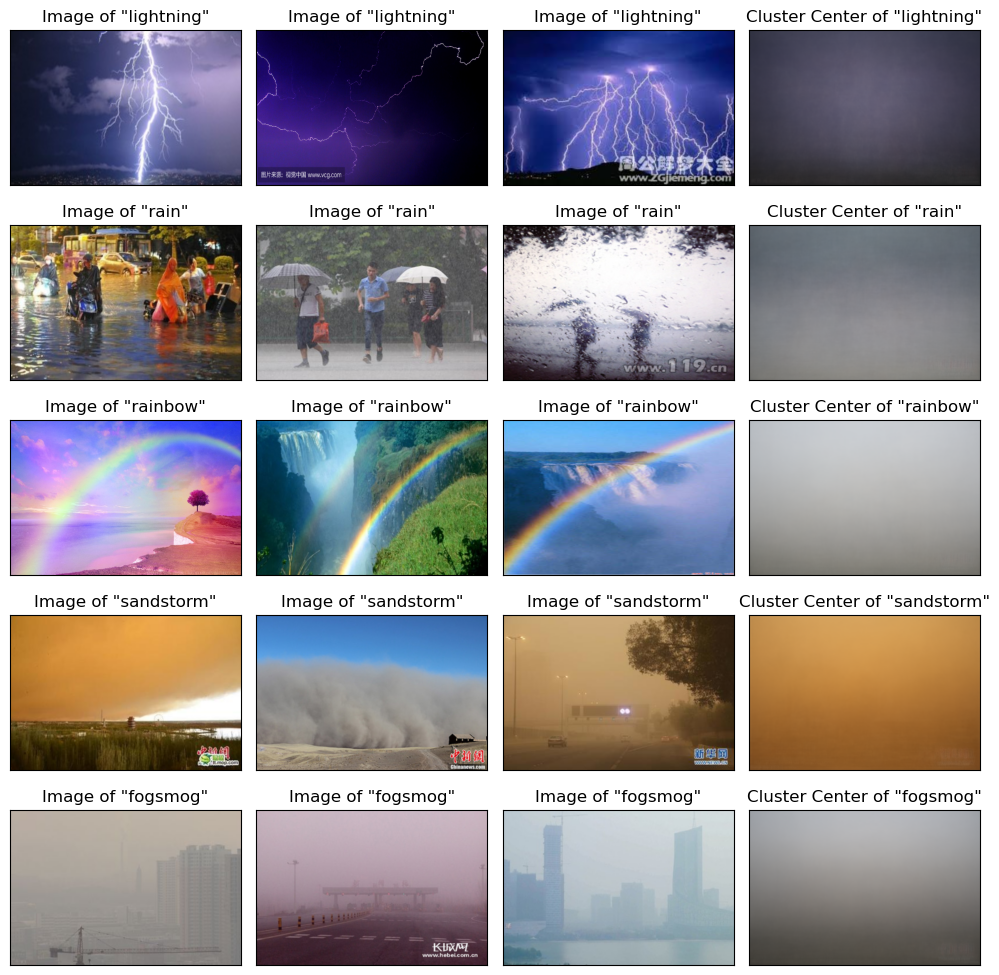

In [63]:
nrows = num_classes
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

for row, label in enumerate(unique_labels):
    cid = int(conf_matrix.columns[np.where(conf_matrix.index==label)[0][0]][-1])
    subset = np.array(labeled_images.filter(lambda x: x[1]==label).map(lambda x: x[0]).takeSample(withReplacement=False, num=ncols-1))
    
    for col, image in enumerate(subset):
        axis = ax[row, col]
        axis.imshow(image.reshape(dimensions))
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_title(f'Image of "{label}"')

    axis = ax[row, ncols-1]
    
    axis.imshow(np.round(cluster_centers[cid][1]).astype('uint8').reshape(dimensions))
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f'Cluster Center of "{label}"')

fig.tight_layout()
plt.savefig('cluster_centers.png', bbox_inches='tight')
plt.show()

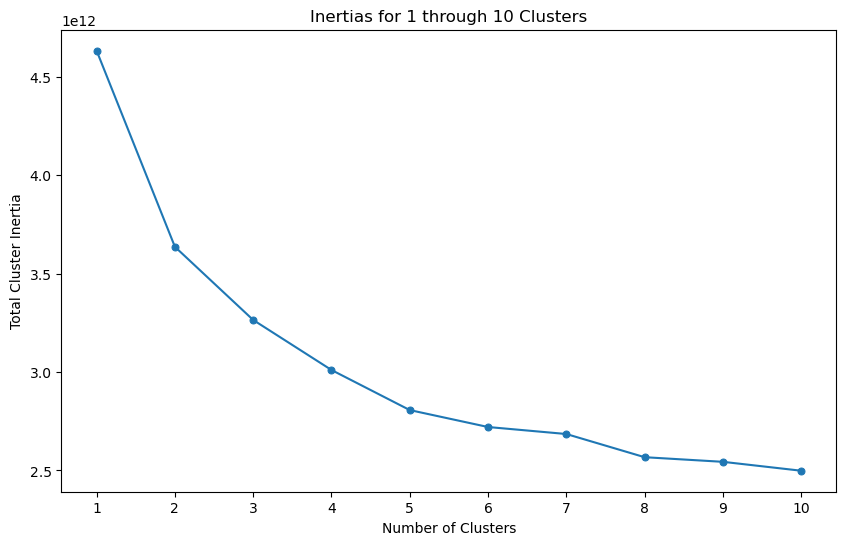

In [90]:
df = pd.read_pickle('inertias.pkl')

plt.close()
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='num_clusters', y='inertia', marker='.', markersize=10, markeredgecolor=sns.color_palette()[0])
plt.xticks(range(1, 11), range(1,11))
plt.xlabel('Number of Clusters')
plt.ylabel('Total Cluster Inertia')
plt.title('Inertias for 1 through 10 Clusters')

plt.savefig('inertias.png', bbox_inches='tight')
plt.show()

# Iris Data Comparison

In [23]:
data = load_iris().data
labels = load_iris().target

data = [(index, val) for index, val in zip(range(len(data)), data)]
labels = [(index, val) for index, val in zip(range(len(data)), labels)]

data = sc.parallelize(data)
labels = sc.parallelize(labels)

In [24]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
predictions = kmeans.predict(data)

  2%|▏         | 5/300 [00:08<08:17,  1.68s/it]


In [33]:
output = labels.join(predictions).map(lambda x: ((x[1][0], x[1][1]), 1)).reduceByKey(lambda x,y: x+y).map(lambda x: {'actual':x[0][0], 'predicted':x[0][1], 'frequency':x[1]}).collect()
output = pd.DataFrame(output)
output

,actual,predicted,frequency
0,1,1,3
1,1,2,47
2,0,0,50
3,2,2,14
4,2,1,36


In [34]:
clustering_accuracy(output, 3)

(0.8866666666666667,
 array([[50.,  0.,  0.],
        [ 0., 47.,  3.],
        [ 0., 14., 36.]]),
 (0, 2, 1))

In [36]:
skmeans = SKMeans(n_clusters=3)

In [37]:
skmeans.fit(load_iris().data)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [39]:
predictions = skmeans.predict(load_iris().data)

In [41]:
pairs = [{'actual':x, 'predicted':y} for x,y in zip(load_iris().target, predictions)]
df = pd.DataFrame(pairs)
df['frequency'] = 1
df = df.groupby(['actual', 'predicted'], as_index=False).sum()
df

,actual,predicted,frequency
0,0,0,50
1,1,1,48
2,1,2,2
3,2,1,14
4,2,2,36


In [42]:
clustering_accuracy(df, 3)

(0.8933333333333333,
 array([[50.,  0.,  0.],
        [ 0., 48.,  2.],
        [ 0., 14., 36.]]),
 (0, 1, 2))